In [1]:

# Jupyterでmatplotlibを使用する宣言と、使用するライブラリの定義
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

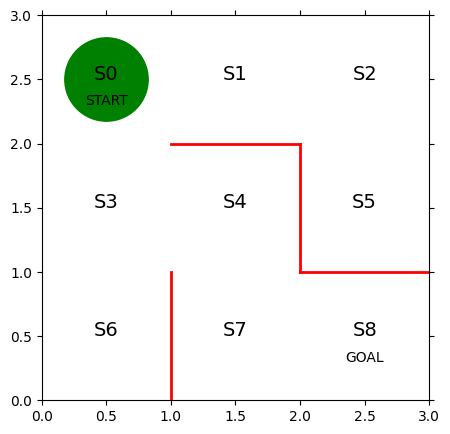

In [2]:

# 初期位置での迷路の様子
 
# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
 
# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)
 
# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')
 
# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')
 
# 現在値S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [3]:

# 初期の方策を決定するパラメータtheta_0を設定
 
# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [10]:
#Sarsaアルゴリズムの実装
# 初期の行動価値関数Qをランダムに設定
 
[a, b] = theta_0.shape  # theta行列行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0
# theta行列と同サイズのランダムな行列を作る
# *theta0をすることで要素ごとに掛け算をし、壁方向をnanに修正する
print(Q)

[[       nan 0.69701867 0.82333863        nan]
 [       nan 0.06714209        nan 0.5819635 ]
 [       nan        nan 0.79499031 0.57514245]
 [0.14761208 0.98967302 0.83104915        nan]
 [       nan        nan 0.82142027 0.80764495]
 [0.6861798         nan        nan        nan]
 [0.33903043        nan        nan        nan]
 [0.41769333 0.51176881        nan        nan]]


In [11]:

# 方策パラメータtheta_0をランダム方策piに変換する関数の定義
 
def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''
 
    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算
 
    pi = np.nan_to_num(pi)  # nanを0に変換
 
    return pi
 
# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)

行動aを行動価値関数Qから求める方法（方策）を実装します。単純に考えれば、Qが最大になる行動を採用すれば良いのですが（greedy法と呼びます）、正しいQが求まっていない状態でこの手法を採用すると、ランダムに生成した行動価値関数Qの初期値しだいで行動が確定してしまいます。

そこで、一定の確率εでランダムに行動し、残りの 1 - ε の確率でQが最大になる行動を採用します。この手法をε-greedy法と呼びます。この ε の値は、試行数（エピソード数）が増えるに従い小さくするように設定します。

価値反復法の強化学習では、毎回行動価値関数の最大行動を利用するのではなく、ときにはランダムに移動させる（探査）させる必要があり、これを探査と利用のトレードオフと呼びます。

それでは、ε-greedy法を実装します。はじめにランダムな行動方策pi_0を定義しておきます

In [12]:
# ε-greedy法を実装
 
def get_action_and_s_next(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
 
    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]
 
    # 決めた行動で次の状態を決める
    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる
 
    return [action, s_next]

行動価値関数Q(s,a)が正しい値になるように更新する部分を実装します。この更新を実現する方法には様々なアルゴリズムがあるのですが、今回はSarsaという手法を使用します。

　もし仮に行動価値関数Q(s,a)が正しい値になっていれば、

　　Q(st,at) = Rt+1 + γQ(st+1,at+1)

という関係式が成立します。γは時間割引率を示します。

　ですが学習の途中ではきちんと行動価値関数が求まっていないため、この等号の関係式が成り立ちません。

このときのRt+1 + γQ(st+1,at+1) - Q(st,at)をTD誤差（Temporal difference error）と呼びます。このTD誤差が0になるようにQ(s,a)を更新すれば良いので、Qの更新式は

　　Q(st,at) = Q(st,at) + η * (Rt+1 + γQ(st+1,at+1) - Q(st,at))

となります。ηは学習率を示し、η以降はTD誤差を示す項となっています。この更新式のように、現在のsとa、即時報酬R、次のステップのsとaの5つを使用して行動価値関数Qを更新するため、それぞれの頭文字を採って「Sarsa」と呼ばれます。

それではSarsaによる行動価値関数の更新を実装します。

In [13]:
# Sarsaによる行動価値関数Qの更新
 
def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
 
    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
 
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])
 
    return Q

In [14]:
# Sarsaで迷路を解く関数の定義、状態と行動の履歴および更新したQを出力
 
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト
 
    while (1):  # ゴールするまでループ
        [a, s_next] = get_action_and_s_next(s, Q, epsilon, pi_0)
        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入
 
        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく
 
        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            [a_next, _] = get_action_and_s_next(s_next, Q, epsilon, pi_0)
            # 実際行動しないですが、次の行動a_nextを求めます。
            # 返り値の_は、その変数は無視するという意味です
 
        # 価値関数を更新
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
 
        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next
 
    return [s_a_history, Q]

In [15]:
# Sarsaで迷路を解く
eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1
 
while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))
 
    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2
 
    # Sarsaで迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
 
    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値の変化を出力
    v = new_v
 
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")
 
    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break

エピソード:1
0.09437462463503299
迷路を解くのにかかったステップ数は4です
エピソード:2
0.20596828462185302
迷路を解くのにかかったステップ数は22です
エピソード:3
0.24756888168440894
迷路を解くのにかかったステップ数は22です
エピソード:4
0.08324601016818922
迷路を解くのにかかったステップ数は8です
エピソード:5
0.11330691652982028
迷路を解くのにかかったステップ数は10です
エピソード:6
0.06321681928722345
迷路を解くのにかかったステップ数は6です
エピソード:7
0.08219925939595923
迷路を解くのにかかったステップ数は8です
エピソード:8
0.05060174275792251
迷路を解くのにかかったステップ数は6です
エピソード:9
0.04084562123923119
迷路を解くのにかかったステップ数は4です
エピソード:10
0.036742416755322416
迷路を解くのにかかったステップ数は4です
エピソード:11
0.05323553497878686
迷路を解くのにかかったステップ数は6です
エピソード:12
0.03461427386296978
迷路を解くのにかかったステップ数は4です
エピソード:13
0.03226886779743521
迷路を解くのにかかったステップ数は4です
エピソード:14
0.026878634761668962
迷路を解くのにかかったステップ数は4です
エピソード:15
0.03149825811372242
迷路を解くのにかかったステップ数は6です
エピソード:16
0.020551461036210417
迷路を解くのにかかったステップ数は4です
エピソード:17
0.03055922870278205
迷路を解くのにかかったステップ数は6です
エピソード:18
0.01796424246189665
迷路を解くのにかかったステップ数は4です
エピソード:19
0.030071212384482737
迷路を解くのにかかったステップ数は6です
エピソード:20
0.017095440584212196
迷路を解くのにかかったステップ数は4です
エ

In [16]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
 
 
def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)
 
 
def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)
 
 
#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)
 
HTML(anim.to_html5_video())

C:\Users\ikemix\AppData\Local\Temp\ipykernel_14084\4279641289.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
